In [ ]:
#Credit to:
#https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb for brain data plus how to load it
#https://github.com/deepmind/dsprites-dataset sprite dataset
#https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py for demonstrating how to set up Optuna code
#https://github.com/StefanDenn3r/Unsupervised_Anomaly_Detection_Brain_MRI for model inspiration/code for metric evaluation (Baur, et al. 2021)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import pickle
from PIL import Image
import numpy as np
import json        
from time import time
import os
import tempfile
import gc
import PIL
import matplotlib.pyplot as plt
import math
import random
import optuna
from optuna.trial import TrialState
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    MaskIntensity,
    ThresholdIntensity
)
from monai.utils import set_determinism
from monai.transforms.utils import rescale_array

from custommodels import AutoEnc
from customfunctions import resetSeeds,splitData,loadMedNISTData,loadDSprites,\
    score,metrics,json_reformatter,MedNISTDataset,storeResults,memDebugger,train,objective,getModel,loadProperData,test

import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
resetSeeds() #helps when rerunning cells

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Created temp directory {root_dir}.")

Created temp directory C:\Users\irose\AppData\Local\Temp\tmpsxa9rv5m.


# Required File Loads End Here

In [89]:
train_x,val_x,test_x = loadProperData("ae_sp_.1",root_dir)

Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.


In [90]:

batch_size = 200
train_ds = MedNISTDataset(train_x)
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

val_ds = MedNISTDataset(val_x)
val_loader = DataLoader(val_ds, batch_size=batch_size)

test_ds = MedNISTDataset(test_x)
test_loader = DataLoader(test_ds, batch_size=batch_size)

### Example Train Data:

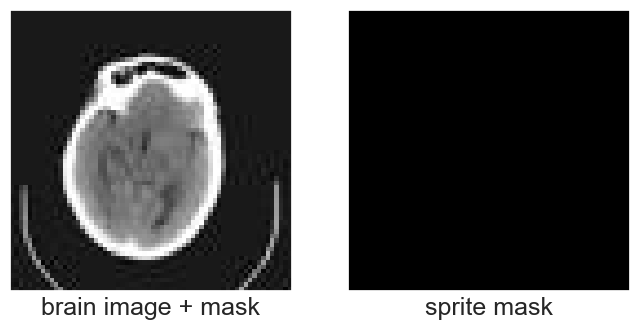

In [104]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"brain image + mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_ds[2030][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"sprite mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_ds[2030][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


### Example Validation Data:

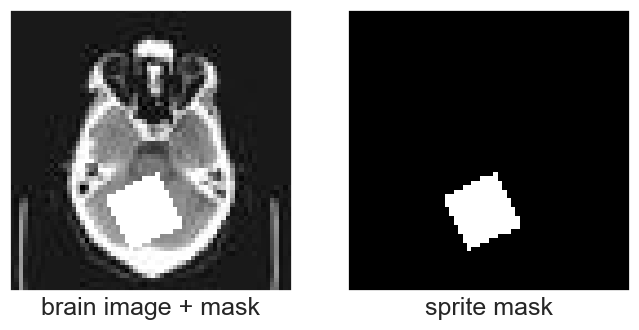

In [102]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"brain image + mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(val_ds[101][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"sprite mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(val_ds[101][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


### Example Test Data:

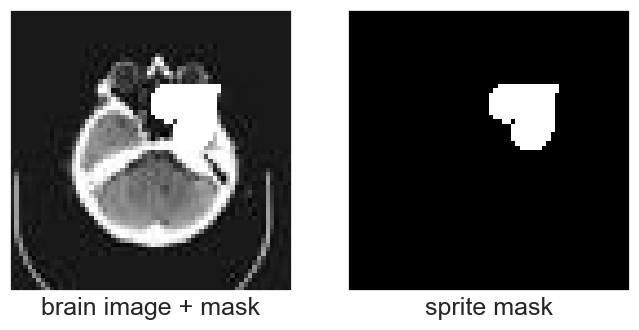

In [103]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"brain image + mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_ds[11][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"sprite mask", fontsize=18)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_ds[11][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


# Example Section on Running, Testing Model

In [ ]:
def loadobjective(trial):
    #experiment types: "ae_usp_.1","ae_sp_.1","ae_semi_.1","vae_usp_.1","vae_sp_.1","vae_semi_.1","cae_usp_.1","cae_sp_.1","cae_semi_.1",
    # "nobottleae_usp_.1","nobottleae_sp_.1","nobottleae_semi_.1","skipae_usp_.1","skipae_sp_.1","skipae_semi_.1"
    experiment_type = "ae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
    batch_size = 125
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

    val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Generate values
    lr = trial.suggest_float("lr", 0.0003, 0.003, log=True) #0.0008603126707594238
    b1= trial.suggest_float("b1", 0.70, 0.95, log=True) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.80, 0.995, log=True) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",.7,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [1,2,3,4] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,2,1,1] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)

    modeltype = getModel(experiment_type)
    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")

    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [ ]:
example_study= optuna.create_study(direction="minimize",study_name="example_study")

num_trials = 1
num_seconds = 3600
example_study.optimize(loadobjective, n_trials=num_trials,timeout=num_seconds,gc_after_trial=True,show_progress_bar=False)

pruned_trials = example_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = example_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(example_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = example_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
file_name_to_run = ""
maskonlyones = True #if false generates randomly (0,1)
test(file_name_to_run,root_dir,maskonlyones)

# Adam/ExponentialLR Hyperparameter Testing

In [ ]:
def loadobjective(trial):
    experiment_type = "ae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
    batch_size = 125
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

    val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Generate values
    lr = trial.suggest_float("lr", 0.0003, 0.003, log=True) #0.0008603126707594238
    b1= trial.suggest_float("b1", 0.70, 0.95, log=True) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.80, 0.995, log=True) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",.7,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [1,2,3,4] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,2,1,1] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)

    modeltype = getModel(experiment_type)
    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")

    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [ ]:
vae_study = optuna.create_study(direction="minimize",study_name="hyperparameter-aetest")

vae_study.optimize(loadobjective, n_trials=20,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import pickle
with open('hyperparameter-aetest.pickle','wb') as f:
    pickle.dump(vae_study,f)


You can also combine studies, which is what I did here (originally I had the output for the previous one, had to reset the outputs of the notebook because it got bugged, unfortunately)

In [5]:
def loadobjective(trial):
    experiment_type = "ae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
    batch_size = 125
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)



    val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)


    # Generate values
    lr = trial.suggest_float("lr", 0.0008, 0.002, step=0.0001) #0.0008603126707594238
    b1= trial.suggest_float("b1", 0.70, 0.95, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= trial.suggest_float("b2", 0.90, 0.995, step=0.001) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = trial.suggest_float("gamma",.7,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [1,2,3,4] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,2,1,1] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)

    modeltype = getModel(experiment_type)
    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [6]:
vae_study = optuna.create_study(direction="minimize",study_name="hyperparameter-aetest2")

vae_study.optimize(loadobjective, n_trials=50,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-08 03:56:09,352] A new study created in memory with name: hyperparameter-aetest2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.7899999999999999, 0.901),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2049
current epoch: 1 
current L1 loss mean: 0.1503 
AUROC: 0.9640 
AUPRC: 0.1284 
DICE score: 0.1430 
Threshold: 0.8000 
best L1 loss mean: 0.1503 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0669
current epoch: 2 
current L1 loss mean: 0.0665 
AUROC: 0.9305 
AUPRC: 0.1229 
DICE score: 0.1596 
Threshold: 0.8000 
best L1 loss mean: 0.0665 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0481
current epoch: 3 
current L1 loss mean: 0.0570 
AUROC: 0.8894 
AUPRC: 0.1144 
DICE score: 0.1524 
Threshold: 0.7700 
best L1 loss mean: 0.0570 at epoch: 3
----------
epoch 4/10
TRAIN: epoch 4 aver

[I 2022-12-08 04:05:39,081] Trial 0 finished with value: 0.03716579079627991 and parameters: {'lr': 0.0014000000000000002, 'b1': 0.7899999999999999, 'b2': 0.901, 'gamma': 0.8999999999999999, 'chosen_loss': 'L1'}. Best is trial 0 with value: 0.03716579079627991.


Saved model at ./models\0-ae_usp_.1,L1,0.0014000000000000002,(0.7899999999999999, 0.901),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.74, 0.912),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1849
current epoch: 1 
current L1 loss mean: 0.1206 
AUROC: 0.9618 
AUPRC: 0.1171 
DICE score: 0.1349 
Threshold: 0.8000 
best L1 loss mean: 0.1206 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0596
current epoch: 2 
current L1 loss mean: 0.0728 
AUROC: 0.9294 
AUPRC: 0.1202 
DICE score: 0.1613 
Threshold: 0.8460 
best L1 loss mean: 0.0728 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0503
current epoch: 3 


[I 2022-12-08 04:15:07,895] Trial 1 finished with value: 0.04183896258473396 and parameters: {'lr': 0.0018, 'b1': 0.74, 'b2': 0.912, 'gamma': 0.85, 'chosen_loss': 'L1'}. Best is trial 0 with value: 0.03716579079627991.


current epoch: 10 
current L1 loss mean: 0.0429 
AUROC: 0.8108 
AUPRC: 0.0806 
DICE score: 0.1192 
Threshold: 0.7060 
best L1 loss mean: 0.0418 at epoch: 9
Storing Results...
train completed, best_metric: 0.0418 at epoch: 9
Saved model at ./models\1-ae_usp_.1,L1,0.0018,(0.74, 0.912),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.9650000000000001),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2228
current epoch: 1 
current L1 loss mean: 0.1613 
AUROC: 0.9729 
AUPRC: 0.1347 
DICE score: 0.1443 
Threshold: 0.4730 
best L1 loss mean: 0.1613 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.1067
current epoch: 2 
current L1 loss mean

[I 2022-12-08 04:24:31,582] Trial 2 finished with value: 0.03274529206100851 and parameters: {'lr': 0.001, 'b1': 0.71, 'b2': 0.9650000000000001, 'gamma': 0.75, 'chosen_loss': 'L1'}. Best is trial 2 with value: 0.03274529206100851.


current epoch: 10 
current L1 loss mean: 0.0328 
AUROC: 0.8156 
AUPRC: 0.0947 
DICE score: 0.1303 
Threshold: 0.6550 
best L1 loss mean: 0.0327 at epoch: 9
Storing Results...
train completed, best_metric: 0.0327 at epoch: 9
Saved model at ./models\2-ae_usp_.1,L1,0.001,(0.71, 0.9650000000000001),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.8799999999999999, 0.902),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2080
current epoch: 1 
current L1 loss mean: 0.1607 
AUROC: 0.9766 
AUPRC: 0.1237 
DICE score: 0.1557 
Threshold: 0.7926 
best L1 loss mean: 0.1607 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0699
current ep

[I 2022-12-08 04:33:33,019] Trial 3 finished with value: 0.0344933473970741 and parameters: {'lr': 0.0014000000000000002, 'b1': 0.8799999999999999, 'b2': 0.902, 'gamma': 0.7, 'chosen_loss': 'L1'}. Best is trial 2 with value: 0.03274529206100851.


Saved model at ./models\3-ae_usp_.1,L1,0.0014000000000000002,(0.8799999999999999, 0.902),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.84, 0.9410000000000001),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1861
current epoch: 1 
current L1 loss mean: 0.1704 
AUROC: 0.9740 
AUPRC: 0.1003 
DICE score: 0.1387 
Threshold: 0.7630 
best L1 loss mean: 0.1704 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0588
current epoch: 2 
current L1 loss mean: 0.0849 
AUROC: 0.9449 
AUPRC: 0.1302 
DICE score: 0.1492 
Threshold: 0.8000 
best L1 loss mean: 0.0849 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0507
current epoch: 3 
cur

[I 2022-12-08 04:42:53,557] Trial 4 finished with value: 0.052535703871399164 and parameters: {'lr': 0.0018, 'b1': 0.84, 'b2': 0.9410000000000001, 'gamma': 1.0, 'chosen_loss': 'L1'}. Best is trial 2 with value: 0.03274529206100851.


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.7799999999999999, 0.908),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1850
current epoch: 1 
current L1 loss mean: 0.1432 
AUROC: 0.9619 
AUPRC: 0.1098 
DICE score: 0.1030 
Threshold: 0.8000 
best L1 loss mean: 0.1432 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0581
current epoch: 2 
current L1 loss mean: 0.0647 
AUROC: 0.9051 
AUPRC: 0.1248 
DICE score: 0.1719 
Threshold: 0.8320 
best L1 loss mean: 0.0647 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0482


[I 2022-12-08 04:45:29,647] Trial 5 pruned. 


current epoch: 3 
current L1 loss mean: 0.0650 
AUROC: 0.9160 
AUPRC: 0.1208 
DICE score: 0.1629 
Threshold: 0.8280 
best L1 loss mean: 0.0647 at epoch: 2
Storing Results...
train completed, best_metric: 0.0647 at epoch: 2
Saved model at ./models\5-ae_usp_.1,L1,0.0018,(0.7799999999999999, 0.908),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0016,(0.77, 0.934),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1936
current epoch: 1 
current L1 loss mean: 0.1599 
AUROC: 0.9633 
AUPRC: 0.1265 
DICE score: 0.1290 
Threshold: 0.8000 
best L1 loss mean: 0.1599 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0627
current epoch: 2 
current L1 loss mean:

[I 2022-12-08 04:48:05,245] Trial 6 pruned. 


current epoch: 3 
current L1 loss mean: 0.0632 
AUROC: 0.9132 
AUPRC: 0.1118 
DICE score: 0.1683 
Threshold: 0.8340 
best L1 loss mean: 0.0632 at epoch: 3
Storing Results...
train completed, best_metric: 0.0632 at epoch: 3
Saved model at ./models\6-ae_usp_.1,L1,0.0016,(0.77, 0.934),0.0002,1.0-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0013,(0.76, 0.927),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2093
current epoch: 1 
current L1 loss mean: 0.1588 
AUROC: 0.9695 
AUPRC: 0.1111 
DICE score: 0.1374 
Threshold: 0.4710 
best L1 loss mean: 0.1588 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0734
current epoch: 2 
current L1 loss mean: 0.0603 
AURO

[I 2022-12-08 04:51:50,077] Trial 7 pruned. 


Saved model at ./models\7-ae_usp_.1,L1,0.0013,(0.76, 0.927),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0012000000000000001,(0.76, 0.98),0.0002,L1,0.95,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2141
current epoch: 1 
current L1 loss mean: 0.1473 
AUROC: 0.9720 
AUPRC: 0.1276 
DICE score: 0.1384 
Threshold: 0.4980 
best L1 loss mean: 0.1473 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0841
current epoch: 2 
current L1 loss mean: 0.0602 
AUROC: 0.9166 
AUPRC: 0.1140 
DICE score: 0.1478 
Threshold: 0.7170 
best L1 loss mean: 0.0602 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0493
current epoch: 3 
current L1 loss mean: 0.0547 

[I 2022-12-08 04:59:20,436] Trial 8 pruned. 


current epoch: 8 
current L1 loss mean: 0.0423 
AUROC: 0.8492 
AUPRC: 0.1246 
DICE score: 0.1634 
Threshold: 0.6760 
best L1 loss mean: 0.0423 at epoch: 8
Storing Results...
train completed, best_metric: 0.0423 at epoch: 8
Saved model at ./models\8-ae_usp_.1,L1,0.0012000000000000001,(0.76, 0.98),0.0002,0.95-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.84, 0.982),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2066
current epoch: 1 
current L1 loss mean: 0.1588 
AUROC: 0.9643 
AUPRC: 0.1062 
DICE score: 0.1392 
Threshold: 0.8000 
best L1 loss mean: 0.1588 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0688
current epoch: 2 
curre

[I 2022-12-08 05:02:10,337] Trial 9 pruned. 


Saved model at ./models\9-ae_usp_.1,L1,0.0014000000000000002,(0.84, 0.982),0.0002,1.0-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0009000000000000001,(0.95, 0.962),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2445


[I 2022-12-08 05:02:48,432] Trial 10 pruned. 


current epoch: 1 
current L1 loss mean: 0.1971 
AUROC: 0.9721 
AUPRC: 0.0879 
DICE score: 0.1505 
Threshold: 0.7478 
best L1 loss mean: 0.1971 at epoch: 1
Storing Results...
train completed, best_metric: 0.1971 at epoch: 1
Saved model at ./models\10-ae_usp_.1,L1,0.0009000000000000001,(0.95, 0.962),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0008,(0.7, 0.9580000000000001),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2340
current epoch: 1 
current L1 loss mean: 0.1617 
AUROC: 0.9291 
AUPRC: 0.0887 
DICE score: 0.1267 
Threshold: 0.7000 
best L1 loss mean: 0.1617 at epoch: 1
Storing Results...


[I 2022-12-08 05:03:51,732] Trial 11 pruned. 


train completed, best_metric: 0.1617 at epoch: 1
Saved model at ./models\11-ae_usp_.1,L1,0.0008,(0.7, 0.9580000000000001),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0011,(0.8999999999999999, 0.9580000000000001),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2285


[I 2022-12-08 05:04:29,172] Trial 12 pruned. 


current epoch: 1 
current L1 loss mean: 0.1798 
AUROC: 0.9743 
AUPRC: 0.0866 
DICE score: 0.1449 
Threshold: 0.7595 
best L1 loss mean: 0.1798 at epoch: 1
Storing Results...
train completed, best_metric: 0.1798 at epoch: 1
Saved model at ./models\12-ae_usp_.1,L1,0.0011,(0.8999999999999999, 0.9580000000000001),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.8899999999999999, 0.995),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2328


[I 2022-12-08 05:05:07,036] Trial 13 pruned. 


current epoch: 1 
current L1 loss mean: 0.1898 
AUROC: 0.9703 
AUPRC: 0.0768 
DICE score: 0.1308 
Threshold: 0.7130 
best L1 loss mean: 0.1898 at epoch: 1
Storing Results...
train completed, best_metric: 0.1898 at epoch: 1
Saved model at ./models\13-ae_usp_.1,L1,0.001,(0.8899999999999999, 0.995),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0016,(0.8799999999999999, 0.919),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2004
current epoch: 1 
current L1 loss mean: 0.1572 
AUROC: 0.9784 
AUPRC: 0.1204 
DICE score: 0.1673 
Threshold: 0.8366 
best L1 loss mean: 0.1572 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0628


[I 2022-12-08 05:06:34,626] Trial 14 pruned. 


current epoch: 2 
current L1 loss mean: 0.0803 
AUROC: 0.9496 
AUPRC: 0.1276 
DICE score: 0.1624 
Threshold: 0.8000 
best L1 loss mean: 0.0803 at epoch: 2
Storing Results...
train completed, best_metric: 0.0803 at epoch: 2
Saved model at ./models\14-ae_usp_.1,L1,0.0016,(0.8799999999999999, 0.919),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.002,(0.7, 0.97),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1772
current epoch: 1 
current L1 loss mean: 0.1053 
AUROC: 0.9482 
AUPRC: 0.1089 
DICE score: 0.1610 
Threshold: 0.8000 
best L1 loss mean: 0.1053 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0600
current epo

[I 2022-12-08 05:09:43,555] Trial 15 pruned. 


current epoch: 3 
current L1 loss mean: 0.0608 
AUROC: 0.9190 
AUPRC: 0.1218 
DICE score: 0.1553 
Threshold: 0.7873 
best L1 loss mean: 0.0608 at epoch: 3
Storing Results...
train completed, best_metric: 0.0608 at epoch: 3
Saved model at ./models\15-ae_usp_.1,L1,0.002,(0.7, 0.97),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0011,(0.82, 0.9380000000000001),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2217


[I 2022-12-08 05:10:21,712] Trial 16 pruned. 


current epoch: 1 
current L1 loss mean: 0.1615 
AUROC: 0.9638 
AUPRC: 0.1016 
DICE score: 0.1201 
Threshold: 0.4857 
best L1 loss mean: 0.1615 at epoch: 1
Storing Results...
train completed, best_metric: 0.1615 at epoch: 1
Saved model at ./models\16-ae_usp_.1,L1,0.0011,(0.82, 0.9380000000000001),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0015,(0.9199999999999999, 0.9490000000000001),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2091


[I 2022-12-08 05:10:55,944] Trial 17 pruned. 


current epoch: 1 
current L1 loss mean: 0.1628 
AUROC: 0.9830 
AUPRC: 0.1231 
DICE score: 0.2091 
Threshold: 0.8292 
best L1 loss mean: 0.1628 at epoch: 1
Storing Results...
train completed, best_metric: 0.1628 at epoch: 1
Saved model at ./models\17-ae_usp_.1,L1,0.0015,(0.9199999999999999, 0.9490000000000001),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0008,(0.86, 0.925),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2414


[I 2022-12-08 05:11:34,455] Trial 18 pruned. 


current epoch: 1 
current L1 loss mean: 0.1976 
AUROC: 0.9607 
AUPRC: 0.0752 
DICE score: 0.1046 
Threshold: 0.7000 
best L1 loss mean: 0.1976 at epoch: 1
Storing Results...
train completed, best_metric: 0.1976 at epoch: 1
Saved model at ./models\18-ae_usp_.1,L1,0.0008,(0.86, 0.925),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0012000000000000001,(0.8099999999999999, 0.9500000000000001),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2171


[I 2022-12-08 05:12:12,047] Trial 19 pruned. 


current epoch: 1 
current L1 loss mean: 0.1621 
AUROC: 0.9658 
AUPRC: 0.1009 
DICE score: 0.1641 
Threshold: 0.8000 
best L1 loss mean: 0.1621 at epoch: 1
Storing Results...
train completed, best_metric: 0.1621 at epoch: 1
Saved model at ./models\19-ae_usp_.1,L1,0.0012000000000000001,(0.8099999999999999, 0.9500000000000001),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.73, 0.972),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2238
current epoch: 1 
current L1 loss mean: 0.1545 
AUROC: 0.9712 
AUPRC: 0.1189 
DICE score: 0.1413 
Threshold: 0.7000 
best L1 loss mean: 0.1545 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.1

[I 2022-12-08 05:14:08,641] Trial 20 pruned. 


current epoch: 2 
current L1 loss mean: 0.0927 
AUROC: 0.7923 
AUPRC: 0.0575 
DICE score: 0.0989 
Threshold: 0.4480 
best L1 loss mean: 0.0927 at epoch: 2
Storing Results...
train completed, best_metric: 0.0927 at epoch: 2
Saved model at ./models\20-ae_usp_.1,L1,0.001,(0.73, 0.972),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.8099999999999999, 0.9),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2047


[I 2022-12-08 05:14:45,588] Trial 21 pruned. 


current epoch: 1 
current L1 loss mean: 0.1611 
AUROC: 0.9652 
AUPRC: 0.1015 
DICE score: 0.1538 
Threshold: 0.8058 
best L1 loss mean: 0.1611 at epoch: 1
Storing Results...
train completed, best_metric: 0.1611 at epoch: 1
Saved model at ./models\21-ae_usp_.1,L1,0.0014000000000000002,(0.8099999999999999, 0.9),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0013,(0.7899999999999999, 0.905),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2105


[I 2022-12-08 05:15:24,671] Trial 22 pruned. 


current epoch: 1 
current L1 loss mean: 0.1711 
AUROC: 0.9672 
AUPRC: 0.1286 
DICE score: 0.1195 
Threshold: 0.7000 
best L1 loss mean: 0.1711 at epoch: 1
Storing Results...
train completed, best_metric: 0.1711 at epoch: 1
Saved model at ./models\22-ae_usp_.1,L1,0.0013,(0.7899999999999999, 0.905),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0016,(0.73, 0.916),0.0002,L1,0.95,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1941


[I 2022-12-08 05:16:05,561] Trial 23 pruned. 


current epoch: 1 
current L1 loss mean: 0.1640 
AUROC: 0.9596 
AUPRC: 0.0753 
DICE score: 0.1008 
Threshold: 0.4715 
best L1 loss mean: 0.1640 at epoch: 1
Storing Results...
train completed, best_metric: 0.1640 at epoch: 1
Saved model at ./models\23-ae_usp_.1,L1,0.0016,(0.73, 0.916),0.0002,0.95-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.86, 0.902),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2083
current epoch: 1 
current L1 loss mean: 0.1570 
AUROC: 0.9738 
AUPRC: 0.0946 
DICE score: 0.1393 
Threshold: 0.7760 
best L1 loss mean: 0.1570 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0674
current epoch: 2 
cur

[I 2022-12-08 05:18:46,880] Trial 24 pruned. 


current epoch: 3 
current L1 loss mean: 0.0571 
AUROC: 0.9126 
AUPRC: 0.1154 
DICE score: 0.1527 
Threshold: 0.7780 
best L1 loss mean: 0.0571 at epoch: 3
Storing Results...
train completed, best_metric: 0.0571 at epoch: 3
Saved model at ./models\24-ae_usp_.1,L1,0.0014000000000000002,(0.86, 0.902),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0015,(0.9199999999999999, 0.921),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2088
current epoch: 1 
current L1 loss mean: 0.1570 
AUROC: 0.9851 
AUPRC: 0.1358 
DICE score: 0.2252 
Threshold: 0.8468 
best L1 loss mean: 0.1570 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0689


[I 2022-12-08 05:20:04,814] Trial 25 pruned. 


current epoch: 2 
current L1 loss mean: 0.0909 
AUROC: 0.9589 
AUPRC: 0.1212 
DICE score: 0.1449 
Threshold: 0.8000 
best L1 loss mean: 0.0909 at epoch: 2
Storing Results...
train completed, best_metric: 0.0909 at epoch: 2
Saved model at ./models\25-ae_usp_.1,L1,0.0015,(0.9199999999999999, 0.921),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0012000000000000001,(0.87, 0.931),0.0002,L1,0.95,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2187


[I 2022-12-08 05:20:42,219] Trial 26 pruned. 


current epoch: 1 
current L1 loss mean: 0.1673 
AUROC: 0.9685 
AUPRC: 0.1069 
DICE score: 0.1461 
Threshold: 0.8032 
best L1 loss mean: 0.1673 at epoch: 1
Storing Results...
train completed, best_metric: 0.1673 at epoch: 1
Saved model at ./models\26-ae_usp_.1,L1,0.0012000000000000001,(0.87, 0.931),0.0002,0.95-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0017000000000000001,(0.84, 0.912),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1917
current epoch: 1 
current L1 loss mean: 0.1563 
AUROC: 0.9721 
AUPRC: 0.1133 
DICE score: 0.1343 
Threshold: 0.8300 
best L1 loss mean: 0.1563 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0596


[I 2022-12-08 05:22:11,168] Trial 27 pruned. 


current epoch: 2 
current L1 loss mean: 0.0772 
AUROC: 0.9340 
AUPRC: 0.1154 
DICE score: 0.1542 
Threshold: 0.8000 
best L1 loss mean: 0.0772 at epoch: 2
Storing Results...
train completed, best_metric: 0.0772 at epoch: 2
Saved model at ./models\27-ae_usp_.1,L1,0.0017000000000000001,(0.84, 0.912),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.002,(0.7899999999999999, 0.968),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1771
current epoch: 1 
current L1 loss mean: 0.1554 
AUROC: 0.9645 
AUPRC: 0.0953 
DICE score: 0.1137 
Threshold: 0.8000 
best L1 loss mean: 0.1554 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0573


[I 2022-12-08 05:23:44,549] Trial 28 pruned. 


current epoch: 2 
current L1 loss mean: 0.0782 
AUROC: 0.9119 
AUPRC: 0.1067 
DICE score: 0.1701 
Threshold: 0.8710 
best L1 loss mean: 0.0782 at epoch: 2
Storing Results...
train completed, best_metric: 0.0782 at epoch: 2
Saved model at ./models\28-ae_usp_.1,L1,0.002,(0.7899999999999999, 0.968),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0013,(0.75, 0.911),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2090
current epoch: 1 
current L1 loss mean: 0.1541 
AUROC: 0.9662 
AUPRC: 0.1243 
DICE score: 0.1244 
Threshold: 0.7000 
best L1 loss mean: 0.1541 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0730
current epoch: 2 
curren

[I 2022-12-08 05:31:24,757] Trial 29 pruned. 


Saved model at ./models\29-ae_usp_.1,L1,0.0013,(0.75, 0.911),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.73, 0.9430000000000001),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2227


[I 2022-12-08 05:32:03,644] Trial 30 pruned. 


current epoch: 1 
current L1 loss mean: 0.1652 
AUROC: 0.9750 
AUPRC: 0.1370 
DICE score: 0.1616 
Threshold: 0.4810 
best L1 loss mean: 0.1652 at epoch: 1
Storing Results...
train completed, best_metric: 0.1652 at epoch: 1
Saved model at ./models\30-ae_usp_.1,L1,0.001,(0.73, 0.9430000000000001),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0019000000000000002,(0.72, 0.909),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1797
current epoch: 1 
current L1 loss mean: 0.1393 
AUROC: 0.9602 
AUPRC: 0.1095 
DICE score: 0.1168 
Threshold: 0.8000 
best L1 loss mean: 0.1393 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0596


[I 2022-12-08 05:33:39,540] Trial 31 pruned. 


current epoch: 2 
current L1 loss mean: 0.0791 
AUROC: 0.9124 
AUPRC: 0.1056 
DICE score: 0.1822 
Threshold: 0.8690 
best L1 loss mean: 0.0791 at epoch: 2
Storing Results...
train completed, best_metric: 0.0791 at epoch: 2
Saved model at ./models\31-ae_usp_.1,L1,0.0019000000000000002,(0.72, 0.909),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0017000000000000001,(0.71, 0.901),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1887
current epoch: 1 
current L1 loss mean: 0.1053 
AUROC: 0.9656 
AUPRC: 0.1213 
DICE score: 0.1583 
Threshold: 0.8000 
best L1 loss mean: 0.1053 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0611
current epoch: 2 
cu

[I 2022-12-08 05:36:07,842] Trial 32 pruned. 


current epoch: 3 
current L1 loss mean: 0.0659 
AUROC: 0.8779 
AUPRC: 0.1029 
DICE score: 0.1740 
Threshold: 0.8610 
best L1 loss mean: 0.0659 at epoch: 3
Storing Results...
train completed, best_metric: 0.0659 at epoch: 3
Saved model at ./models\32-ae_usp_.1,L1,0.0017000000000000001,(0.71, 0.901),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.75, 0.915),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1854
current epoch: 1 
current L1 loss mean: 0.1482 
AUROC: 0.9673 
AUPRC: 0.1168 
DICE score: 0.1808 
Threshold: 0.8175 
best L1 loss mean: 0.1482 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0594
current epoch: 2 
cur

[I 2022-12-08 05:38:38,864] Trial 33 pruned. 


Saved model at ./models\33-ae_usp_.1,L1,0.0018,(0.75, 0.915),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0015,(0.7799999999999999, 0.923),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1991


[I 2022-12-08 05:39:15,375] Trial 34 pruned. 


current epoch: 1 
current L1 loss mean: 0.1626 
AUROC: 0.9599 
AUPRC: 0.1062 
DICE score: 0.1360 
Threshold: 0.8000 
best L1 loss mean: 0.1626 at epoch: 1
Storing Results...
train completed, best_metric: 0.1626 at epoch: 1
Saved model at ./models\34-ae_usp_.1,L1,0.0015,(0.7799999999999999, 0.923),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0017000000000000001,(0.74, 0.908),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1888
current epoch: 1 
current L1 loss mean: 0.1521 
AUROC: 0.9636 
AUPRC: 0.1044 
DICE score: 0.1507 
Threshold: 0.8000 
best L1 loss mean: 0.1521 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0599
current epoch: 2 
curr

[I 2022-12-08 05:42:52,184] Trial 35 pruned. 


Saved model at ./models\35-ae_usp_.1,L1,0.0017000000000000001,(0.74, 0.908),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0019000000000000002,(0.77, 0.931),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1817
current epoch: 1 
current L1 loss mean: 0.1454 
AUROC: 0.9572 
AUPRC: 0.0767 
DICE score: 0.0970 
Threshold: 0.5173 
best L1 loss mean: 0.1454 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0587
current epoch: 2 
current L1 loss mean: 0.0685 
AUROC: 0.9248 
AUPRC: 0.1366 
DICE score: 0.1885 
Threshold: 0.8340 
best L1 loss mean: 0.0685 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0496


[I 2022-12-08 05:45:32,116] Trial 36 pruned. 


current epoch: 3 
current L1 loss mean: 0.0581 
AUROC: 0.8562 
AUPRC: 0.1207 
DICE score: 0.1613 
Threshold: 0.8000 
best L1 loss mean: 0.0581 at epoch: 3
Storing Results...
train completed, best_metric: 0.0581 at epoch: 3
Saved model at ./models\36-ae_usp_.1,L1,0.0019000000000000002,(0.77, 0.931),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0013,(0.7899999999999999, 0.906),0.0002,L1,0.95,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2092
current epoch: 1 
current L1 loss mean: 0.1565 
AUROC: 0.9633 
AUPRC: 0.1345 
DICE score: 0.1377 
Threshold: 0.8000 
best L1 loss mean: 0.1565 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0709
current epoch: 2 
cur

[I 2022-12-08 05:48:06,444] Trial 37 pruned. 


current epoch: 3 
current L1 loss mean: 0.0594 
AUROC: 0.8927 
AUPRC: 0.1254 
DICE score: 0.1827 
Threshold: 0.8350 
best L1 loss mean: 0.0585 at epoch: 2
Storing Results...
train completed, best_metric: 0.0585 at epoch: 2
Saved model at ./models\37-ae_usp_.1,L1,0.0013,(0.7899999999999999, 0.906),0.0002,0.95-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0009000000000000001,(0.76, 0.979),0.0002,L1,0.85,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2295


[I 2022-12-08 05:48:43,756] Trial 38 pruned. 


current epoch: 1 
current L1 loss mean: 0.1687 
AUROC: 0.9682 
AUPRC: 0.1013 
DICE score: 0.1328 
Threshold: 0.4701 
best L1 loss mean: 0.1687 at epoch: 1
Storing Results...
train completed, best_metric: 0.1687 at epoch: 1
Saved model at ./models\38-ae_usp_.1,L1,0.0009000000000000001,(0.76, 0.979),0.0002,0.85-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0011,(0.71, 0.916),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2189
current epoch: 1 
current L1 loss mean: 0.1580 
AUROC: 0.9684 
AUPRC: 0.1289 
DICE score: 0.1498 
Threshold: 0.6835 
best L1 loss mean: 0.1580 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0890
current epoch: 2 
current L1 loss me

[I 2022-12-08 05:51:37,460] Trial 39 pruned. 


current epoch: 3 
current L1 loss mean: 0.0573 
AUROC: 0.8761 
AUPRC: 0.1147 
DICE score: 0.1560 
Threshold: 0.7800 
best L1 loss mean: 0.0573 at epoch: 3
Storing Results...
train completed, best_metric: 0.0573 at epoch: 3
Saved model at ./models\39-ae_usp_.1,L1,0.0011,(0.71, 0.916),0.0002,1.0-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0014000000000000002,(0.8099999999999999, 0.9540000000000001),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2051


[I 2022-12-08 05:52:13,771] Trial 40 pruned. 


current epoch: 1 
current L1 loss mean: 0.1682 
AUROC: 0.9661 
AUPRC: 0.1216 
DICE score: 0.1162 
Threshold: 0.5419 
best L1 loss mean: 0.1682 at epoch: 1
Storing Results...
train completed, best_metric: 0.1682 at epoch: 1
Saved model at ./models\40-ae_usp_.1,L1,0.0014000000000000002,(0.8099999999999999, 0.9540000000000001),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.85, 0.9400000000000001),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1892
current epoch: 1 
current L1 loss mean: 0.1566 
AUROC: 0.9715 
AUPRC: 0.0944 
DICE score: 0.1354 
Threshold: 0.8352 
best L1 loss mean: 0.1566 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0

[I 2022-12-08 05:53:40,687] Trial 41 pruned. 


current epoch: 2 
current L1 loss mean: 0.0855 
AUROC: 0.9422 
AUPRC: 0.1204 
DICE score: 0.1500 
Threshold: 0.8000 
best L1 loss mean: 0.0855 at epoch: 2
Storing Results...
train completed, best_metric: 0.0855 at epoch: 2
Saved model at ./models\41-ae_usp_.1,L1,0.0018,(0.85, 0.9400000000000001),0.0002,1.0-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0016,(0.83, 0.966),0.0002,L1,1.0,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1967
current epoch: 1 
current L1 loss mean: 0.1407 
AUROC: 0.9591 
AUPRC: 0.1000 
DICE score: 0.1320 
Threshold: 0.8000 
best L1 loss mean: 0.1407 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0624


[I 2022-12-08 05:55:07,100] Trial 42 pruned. 


current epoch: 2 
current L1 loss mean: 0.0790 
AUROC: 0.9502 
AUPRC: 0.1384 
DICE score: 0.1759 
Threshold: 0.8130 
best L1 loss mean: 0.0790 at epoch: 2
Storing Results...
train completed, best_metric: 0.0790 at epoch: 2
Saved model at ./models\42-ae_usp_.1,L1,0.0016,(0.83, 0.966),0.0002,1.0-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0019000000000000002,(0.8999999999999999, 0.978),0.0002,L1,0.95,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1862
current epoch: 1 
current L1 loss mean: 0.1514 
AUROC: 0.9808 
AUPRC: 0.1046 
DICE score: 0.1852 
Threshold: 0.8577 
best L1 loss mean: 0.1514 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0609


[I 2022-12-08 05:56:26,185] Trial 43 pruned. 


current epoch: 2 
current L1 loss mean: 0.0980 
AUROC: 0.9477 
AUPRC: 0.1210 
DICE score: 0.1294 
Threshold: 0.8000 
best L1 loss mean: 0.0980 at epoch: 2
Storing Results...
train completed, best_metric: 0.0980 at epoch: 2
Saved model at ./models\43-ae_usp_.1,L1,0.0019000000000000002,(0.8999999999999999, 0.978),0.0002,0.95-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0017000000000000001,(0.83, 0.99),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1916
current epoch: 1 
current L1 loss mean: 0.1556 
AUROC: 0.9702 
AUPRC: 0.1174 
DICE score: 0.1584 
Threshold: 0.8259 
best L1 loss mean: 0.1556 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0611
current 

[I 2022-12-08 05:59:08,960] Trial 44 pruned. 


current epoch: 3 
current L1 loss mean: 0.0583 
AUROC: 0.9013 
AUPRC: 0.1050 
DICE score: 0.1407 
Threshold: 0.7600 
best L1 loss mean: 0.0583 at epoch: 3
Storing Results...
train completed, best_metric: 0.0583 at epoch: 3
Saved model at ./models\44-ae_usp_.1,L1,0.0017000000000000001,(0.83, 0.99),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0015,(0.8899999999999999, 0.96),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2046
current epoch: 1 
current L1 loss mean: 0.1498 
AUROC: 0.9663 
AUPRC: 0.1022 
DICE score: 0.1124 
Threshold: 0.7250 
best L1 loss mean: 0.1498 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0662


[I 2022-12-08 06:00:32,136] Trial 45 pruned. 


current epoch: 2 
current L1 loss mean: 0.0786 
AUROC: 0.9527 
AUPRC: 0.1359 
DICE score: 0.1653 
Threshold: 0.8000 
best L1 loss mean: 0.0786 at epoch: 2
Storing Results...
train completed, best_metric: 0.0786 at epoch: 2
Saved model at ./models\45-ae_usp_.1,L1,0.0015,(0.8899999999999999, 0.96),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0018,(0.7, 0.905),0.0002,L1,0.8999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1861
current epoch: 1 
current L1 loss mean: 0.1209 
AUROC: 0.9539 
AUPRC: 0.0976 
DICE score: 0.1300 
Threshold: 0.8000 
best L1 loss mean: 0.1209 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0610
current ep

[I 2022-12-08 06:03:17,425] Trial 46 pruned. 


Saved model at ./models\46-ae_usp_.1,L1,0.0018,(0.7, 0.905),0.0002,0.8999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0016,(0.9199999999999999, 0.928),0.0002,L1,0.7999999999999999,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2030
current epoch: 1 
current L1 loss mean: 0.1556 
AUROC: 0.9863 
AUPRC: 0.1615 
DICE score: 0.2367 
Threshold: 0.8590 
best L1 loss mean: 0.1556 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0659


[I 2022-12-08 06:04:37,537] Trial 47 pruned. 


current epoch: 2 
current L1 loss mean: 0.0770 
AUROC: 0.9605 
AUPRC: 0.1301 
DICE score: 0.1556 
Threshold: 0.8000 
best L1 loss mean: 0.0770 at epoch: 2
Storing Results...
train completed, best_metric: 0.0770 at epoch: 2
Saved model at ./models\47-ae_usp_.1,L1,0.0016,(0.9199999999999999, 0.928),0.0002,0.7999999999999999-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.0013,(0.95, 0.937),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2215


[I 2022-12-08 06:05:14,132] Trial 48 pruned. 


current epoch: 1 
current L1 loss mean: 0.1626 
AUROC: 0.9809 
AUPRC: 0.1149 
DICE score: 0.1911 
Threshold: 0.8252 
best L1 loss mean: 0.1626 at epoch: 1
Storing Results...
train completed, best_metric: 0.1626 at epoch: 1
Saved model at ./models\48-ae_usp_.1,L1,0.0013,(0.95, 0.937),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.002,(0.85, 0.9540000000000001),0.0002,L1,0.7,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1802
current epoch: 1 
current L1 loss mean: 0.1506 
AUROC: 0.9737 
AUPRC: 0.1065 
DICE score: 0.1457 
Threshold: 0.8524 
best L1 loss mean: 0.1506 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0574


[I 2022-12-08 06:06:36,660] Trial 49 pruned. 


current epoch: 2 
current L1 loss mean: 0.0797 
AUROC: 0.9499 
AUPRC: 0.1316 
DICE score: 0.1634 
Threshold: 0.8000 
best L1 loss mean: 0.0797 at epoch: 2
Storing Results...
train completed, best_metric: 0.0797 at epoch: 2
Saved model at ./models\49-ae_usp_.1,L1,0.002,(0.85, 0.9540000000000001),0.0002,0.7-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  45
  Number of complete trials:  5
Best trial:
  Value:  0.03274529206100851
  Params: 
    lr: 0.001
    b1: 0.71
    b2: 0.9650000000000001
    gamma: 0.75
    chosen_loss: L1


In [9]:
statlist = []
for v in vae_study.trials:
    num = v.number
    state = v.state
    params = v.params.values()
    scores = list(v.intermediate_values.values())
    if len(scores)<1:
        scores = [100000]
    statlist.append((num,state,params,scores[-1]))
print(sorted(statlist,key=lambda x: x[3]))

[(2, TrialState.COMPLETE, dict_values([0.001, 0.71, 0.9650000000000001, 0.75, 'L1']), 0.03277667600195855), (3, TrialState.COMPLETE, dict_values([0.0014000000000000002, 0.8799999999999999, 0.902, 0.7, 'L1']), 0.035211026668548584), (0, TrialState.COMPLETE, dict_values([0.0014000000000000002, 0.7899999999999999, 0.901, 0.8999999999999999, 'L1']), 0.03838572953827679), (29, TrialState.PRUNED, dict_values([0.0013, 0.75, 0.911, 0.8999999999999999, 'L1']), 0.04191062832251191), (8, TrialState.PRUNED, dict_values([0.0012000000000000001, 0.76, 0.98, 0.95, 'L1']), 0.04228188586421311), (1, TrialState.COMPLETE, dict_values([0.0018, 0.74, 0.912, 0.85, 'L1']), 0.04291578382253647), (35, TrialState.PRUNED, dict_values([0.0017000000000000001, 0.74, 0.908, 0.7, 'L1']), 0.04824689985252917), (7, TrialState.PRUNED, dict_values([0.0013, 0.76, 0.927, 0.85, 'L1']), 0.04941639490425587), (4, TrialState.COMPLETE, dict_values([0.0018, 0.84, 0.9410000000000001, 1.0, 'L1']), 0.052535703871399164), (24, TrialS

In [7]:
import pickle
with open('hyperparameter-aetest2.pickle','wb') as f:
    pickle.dump(vae_study,f)


In [ ]:
'''Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  45
  Number of complete trials:  5
Best trial:
  Value:  0.03274529206100851
  Params: 
    lr: 0.001
    b1: 0.71
    b2: 0.9650000000000001
    gamma: 0.75
    chosen_loss: L1'''

# Unsupervised AE (Dense) - AE Internal Hyperparameter Testing

In [108]:
def loadobjective(trial):
    experiment_type = "ae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),\
        trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),\
        trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [ ]:
vae_study = optuna.create_study(direction="minimize",study_name="hyperparameter-aetest3")

In [114]:
vae_study.optimize(loadobjective, n_trials=50,timeout=3600,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [5, 3, 3, 3], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1565
current epoch: 1 
current L1 loss mean: 0.1002 
AUROC: 0.8983 AUPRC: 0.1173 DICE score: 0.1505 Threshold: 0.7000 
best L1 loss mean: 0.1002 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0682
current epoch: 2 
current L1 loss mean: 0.0633 
AUROC: 0.8964 AUPRC: 0.1196 DICE score: 0.1628 Threshold: 0.7800 
best L1 loss mean: 0.0633 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0477
current epoch: 3 
current L1 loss mean: 0.0554 
AUROC: 0.9216 AUPRC: 0.1095 DICE score: 0.1341 Threshold: 0.7000 
best L1 loss mean: 0.0554 at epoch: 3
----------
epoch 4/10
TRAIN: epoch 4 average loss: 0.0433
current epoch: 4 
cur

[I 2022-12-09 11:31:29,143] Trial 13 finished with value: 0.03398896043654531 and parameters: {'kernel_sizea': 5, 'kernel_sizeb': 3, 'kernel_sizec': 3, 'kernel_sized': 3, 'stridea': 1, 'strideb': 2, 'stridec': 1, 'strided': 1, 'paddinga': 1, 'paddingb': 1, 'paddingc': 1, 'paddingd': 2, 'latent': 128, 'chosen_loss': 'L1'}. Best is trial 13 with value: 0.03398896043654531.


current epoch: 10 
current L1 loss mean: 0.0347 
AUROC: 0.7476 AUPRC: 0.0967 DICE score: 0.1473 Threshold: 0.6730 
best L1 loss mean: 0.0340 at epoch: 9
Storing Results...
train completed, best_metric: 0.0340 at epoch: 9
Saved model at ./models\13-ae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[5, 3, 3, 3]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [4, 3, 4, 3], 'stride': [1, 1, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1806
current epoch: 1 
current L1 loss mean: 0.1624 
AUROC: 0.9419 AUPRC: 0.0965 DICE score: 0.1477 Threshold: 0.5122 
best L1 loss mean: 0.1624 at epoch: 1
Storing Results...
train completed, best_metric: 0.1624 at epoch: 1


[I 2022-12-09 11:34:06,865] Trial 14 pruned. 


Saved model at ./models\14-ae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[4, 3, 4, 3]&stride#[1, 1, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [4, 4, 3, 2], 'stride': [1, 2, 1, 1], 'padding': [2, 2, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1623
current epoch: 1 
current L1 loss mean: 0.1340 
AUROC: 0.9610 AUPRC: 0.1128 DICE score: 0.1572 Threshold: 0.8000 
best L1 loss mean: 0.1340 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0646
current epoch: 2 
current L1 loss mean: 0.0622 
AUROC: 0.8541 AUPRC: 0.1092 DICE score: 0.1572 Threshold: 0.7400 
best L1 loss mean: 0.0622 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0467
current epoch: 3 
current L1 loss mean: 0.

[I 2022-12-09 11:44:58,909] Trial 15 finished with value: 0.033131793956272304 and parameters: {'kernel_sizea': 4, 'kernel_sizeb': 4, 'kernel_sizec': 3, 'kernel_sized': 2, 'stridea': 1, 'strideb': 2, 'stridec': 1, 'strided': 1, 'paddinga': 2, 'paddingb': 2, 'paddingc': 1, 'paddingd': 2, 'latent': 128, 'chosen_loss': 'L1'}. Best is trial 15 with value: 0.033131793956272304.


current epoch: 10 
current L1 loss mean: 0.0331 
AUROC: 0.8105 AUPRC: 0.0941 DICE score: 0.1378 Threshold: 0.6380 
best L1 loss mean: 0.0331 at epoch: 10
Storing Results...
train completed, best_metric: 0.0331 at epoch: 10
Saved model at ./models\15-ae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[4, 4, 3, 2]&stride#[1, 2, 1, 1]&padding#[2, 2, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [5, 4, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1332
current epoch: 1 
current L1 loss mean: 0.0997 
AUROC: 0.9594 AUPRC: 0.1170 DICE score: 0.1519 Threshold: 0.8000 
best L1 loss mean: 0.0997 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0570
current epoch: 2 
current L1 

[I 2022-12-09 11:54:29,336] Trial 16 finished with value: 0.03299871017225087 and parameters: {'kernel_sizea': 5, 'kernel_sizeb': 4, 'kernel_sizec': 4, 'kernel_sized': 2, 'stridea': 1, 'strideb': 2, 'stridec': 1, 'strided': 1, 'paddinga': 1, 'paddingb': 1, 'paddingc': 1, 'paddingd': 2, 'latent': 128, 'chosen_loss': 'L1'}. Best is trial 16 with value: 0.03299871017225087.


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [4, 4, 4, 1], 'stride': [1, 2, 1, 1], 'padding': [2, 2, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1710


[I 2022-12-09 11:55:46,737] Trial 17 pruned. 


current epoch: 1 
current L1 loss mean: 0.1401 
AUROC: 0.9299 AUPRC: 0.1222 DICE score: 0.1523 Threshold: 0.7000 
best L1 loss mean: 0.1401 at epoch: 1
Storing Results...
train completed, best_metric: 0.1401 at epoch: 1
Saved model at ./models\17-ae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[4, 4, 4, 1]&stride#[1, 2, 1, 1]&padding#[2, 2, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [5, 4, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1327
current epoch: 1 
current L1 loss mean: 0.1147 
AUROC: 0.9588 AUPRC: 0.1318 DICE score: 0.1418 Threshold: 0.8000 
best L1 loss mean: 0.1147 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0570
current epoch: 2 
current L1 los

[I 2022-12-09 12:05:59,347] Trial 18 finished with value: 0.03335258027072996 and parameters: {'kernel_sizea': 5, 'kernel_sizeb': 4, 'kernel_sizec': 4, 'kernel_sized': 2, 'stridea': 1, 'strideb': 2, 'stridec': 1, 'strided': 1, 'paddinga': 1, 'paddingb': 1, 'paddingc': 1, 'paddingd': 2, 'latent': 128, 'chosen_loss': 'L1'}. Best is trial 16 with value: 0.03299871017225087.


Saved model at ./models\18-ae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[5, 4, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [4, 4, 5, 2], 'stride': [1, 2, 2, 2], 'padding': [2, 2, 2, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1770
current epoch: 1 
current L1 loss mean: 0.0960 
AUROC: 0.9298 AUPRC: 0.0993 DICE score: 0.1283 Threshold: 0.7000 
best L1 loss mean: 0.0960 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0772
current epoch: 2 
current L1 loss mean: 0.0661 
AUROC: 0.8235 AUPRC: 0.1171 DICE score: 0.1675 Threshold: 0.7350 
best L1 loss mean: 0.0661 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0530
current epoch: 3 
current L1 loss mean: 0.

[I 2022-12-09 12:13:28,998] Trial 19 pruned. 


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1929
current epoch: 1 
current L1 loss mean: 0.1300 
AUROC: 0.9601 AUPRC: 0.1320 DICE score: 0.1436 Threshold: 0.7100 
best L1 loss mean: 0.1300 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0904
current epoch: 2 
current L1 loss mean: 0.0685 
AUROC: 0.7531 AUPRC: 0.1178 DICE score: 0.1668 Threshold: 0.4990 
best L1 loss mean: 0.0685 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0533
current epoch: 3 
current L1 loss mean: 0.0537 
AUROC: 0.7920 AUPRC: 0.1033 DICE score: 0.1406 Threshold: 0.7090 
best L1 loss mean: 0.0537 at epoch: 3
----------
epoch 4/10
TRAIN: epoch 4 average loss: 0.0432
current epoch: 4 
cur

[I 2022-12-09 12:23:50,487] Trial 20 finished with value: 0.032703754608519375 and parameters: {'kernel_sizea': 3, 'kernel_sizeb': 2, 'kernel_sizec': 4, 'kernel_sized': 2, 'stridea': 1, 'strideb': 2, 'stridec': 1, 'strided': 1, 'paddinga': 1, 'paddingb': 1, 'paddingc': 1, 'paddingd': 2, 'latent': 128, 'chosen_loss': 'L1'}. Best is trial 20 with value: 0.032703754608519375.


Study statistics: 
  Number of finished trials:  21
  Number of pruned trials:  7
  Number of complete trials:  12
Best trial:
  Value:  0.032703754608519375
  Params: 
    kernel_sizea: 3
    kernel_sizeb: 2
    kernel_sizec: 4
    kernel_sized: 2
    stridea: 1
    strideb: 2
    stridec: 1
    strided: 1
    paddinga: 1
    paddingb: 1
    paddingc: 1
    paddingd: 2
    latent: 128
    chosen_loss: L1


In [117]:
import pickle
with open('hyperparameter-aetest3.pickle','wb') as f:
    pickle.dump(vae_study,f)


In [22]:
with open('hyperparameter-aetest.pickle','rb') as f:
    vae_study2a  = pickle.load(f)


In [19]:
with open('hyperparameter-aetest2.pickle','rb') as f:
    vae_study2 = pickle.load(f)


In [25]:
for trial in vae_study2a.trials:
    if trial.params["weight_decay"] == 0.0002:
        vae_study2.add_trial(trial)

In [28]:
fig = optuna.visualization.plot_intermediate_values(vae_study2)
fig.show()

In [5]:
with open('hyperparameter-aetest3.pickle','rb') as f:
    vae_study22 = pickle.load(f)


In [16]:
print("Best trial:")
trial = vae_study22.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.032703754608519375
  Params: 
    kernel_sizea: 3
    kernel_sizeb: 2
    kernel_sizec: 4
    kernel_sized: 2
    stridea: 1
    strideb: 2
    stridec: 1
    strided: 1
    paddinga: 1
    paddingb: 1
    paddingc: 1
    paddingd: 2
    latent: 128
    chosen_loss: L1


In [29]:
fig = optuna.visualization.plot_intermediate_values(vae_study22)
fig.show()

In [115]:
gc.collect()

567762

## VAE USP

In [12]:
def loadobjective(trial):
    experiment_type = "vae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
    batch_size = 125
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)


    #train_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    #transform=torchvision.transforms.Compose([
    #    torchvision.transforms.ToTensor(),
    #    torchvision.transforms.Resize(64)
    #])),
    #batch_size=200,shuffle=False)

    #val_loader=torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/',train=True,download=True,
    #transform=torchvision.transforms.Compose([
    #    torchvision.transforms.ToTensor(),
    #    torchvision.transforms.Resize(64)
    #])),
    #batch_size=200,shuffle=False)


    val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [1,2,3,4] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,2,1,1] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)

    modeltype = getModel(experiment_type)
    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [13]:
vae_study = optuna.create_study(direction="minimize",study_name="vae-usp")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-08 11:09:53,004] A new study created in memory with name: vae-usp


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,KL,0.75,{'num_layers': 4, 'kernel_size': [1, 2, 3, 4], 'stride': [1, 2, 1, 1], 'padding': [1, 2, 1, 1], 'dilation': [1, 1, 1, 1]}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 1765.6608
current epoch: 1 
current KL loss mean: 511.9080 
AUROC: 0.9663 AUPRC: 0.0881 DICE score: 0.1200 Threshold: 0.5078 
best KL loss mean: 511.9080 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 382.4247
current epoch: 2 
current KL loss mean: 362.8000 
AUROC: 0.9350 AUPRC: 0.0980 DICE score: 0.1482 Threshold: 0.8000 
best KL loss mean: 362.8000 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 330.2114
current epoch: 3 
current KL loss mean: 336.5507 
AUROC: 0.8619 AUPRC: 0.0767 DICE score: 0.1586 Threshold: 0.8599 
best KL loss mean: 336.5507 at epoch: 3
----------
epoch 4/10
TRAIN: epoch 4 average loss: 312.6162
current epoch: 

[I 2022-12-08 11:19:31,440] Trial 0 finished with value: 292.01197814941406 and parameters: {'chosen_loss': 'KL'}. Best is trial 0 with value: 292.01197814941406.


current epoch: 10 
current KL loss mean: 292.0120 
AUROC: 0.8390 AUPRC: 0.0752 DICE score: 0.1640 Threshold: 0.8444 
best KL loss mean: 292.0120 at epoch: 10
Storing Results...
train completed, best_metric: 292.0120 at epoch: 10
Saved model at ./models\0-vae_usp_.1,KL,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[1, 2, 3, 4]&stride#[1, 2, 1, 1]&padding#[1, 2, 1, 1]&dilation#[1, 1, 1, 1].pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  292.01197814941406
  Params: 
    chosen_loss: KL


In [14]:
import pickle
with open('vae-usp.pickle','wb') as f:
    pickle.dump(vae_study,f)


In [17]:
def loadobjective(trial):
    experiment_type = "vae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [18]:
vae_study = optuna.create_study(direction="minimize",study_name="vae-usp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 12:54:20,512] A new study created in memory with name: vae-usp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,KL,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 1014.5551
current epoch: 1 
current KL loss mean: 500.2032 
AUROC: 0.9534 AUPRC: 0.0810 DICE score: 0.1250 Threshold: 0.8000 
best KL loss mean: 500.2032 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 403.7898
current epoch: 2 
current KL loss mean: 393.0592 
AUROC: 0.7816 AUPRC: 0.0579 DICE score: 0.1399 Threshold: 0.8000 
best KL loss mean: 393.0592 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 336.0156
current epoch: 3 
current KL loss mean: 353.8449 
AUROC: 0.8136 AUPRC: 0.0776 DICE score: 0.1854 Threshold: 0.8550 
best KL loss mean: 353.8449 at epoch: 3
----------
epoch 4/10
TRAIN: epoch 4 average loss: 315.1033


[I 2022-12-09 13:04:23,608] Trial 0 finished with value: 296.86814308166504 and parameters: {'chosen_loss': 'KL'}. Best is trial 0 with value: 296.86814308166504.


current epoch: 10 
current KL loss mean: 296.8681 
AUROC: 0.9110 AUPRC: 0.1319 DICE score: 0.2140 Threshold: 0.8510 
best KL loss mean: 296.8681 at epoch: 10
Storing Results...
train completed, best_metric: 296.8681 at epoch: 10
Saved model at ./models\0-vae_usp_.1,KL,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  296.86814308166504
  Params: 
    chosen_loss: KL


In [41]:
import pickle
with open('vae-usp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Unsupervised Constrained AE (Dense)

In [42]:
def loadobjective(trial):
    experiment_type = "cae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [43]:
vae_study = optuna.create_study(direction="minimize",study_name="cae-usp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 14:10:10,439] A new study created in memory with name: cae-usp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,cae,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([12

[I 2022-12-09 14:21:21,591] Trial 0 finished with value: 0.006704953353619203 and parameters: {'chosen_loss': 'cae'}. Best is trial 0 with value: 0.006704953353619203.


current epoch: 10 
current cae loss mean: 0.0067 
AUROC: 0.8599 AUPRC: 0.0963 DICE score: 0.1242 Threshold: 0.5643 
best cae loss mean: 0.0067 at epoch: 10
Storing Results...
train completed, best_metric: 0.0067 at epoch: 10
Saved model at ./models\0-cae_usp_.1,cae,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.006704953353619203
  Params: 
    chosen_loss: cae


In [44]:
import pickle
with open('cae-usp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Unsupervised AE (No Dense)

In [45]:
def loadobjective(trial):
    experiment_type = "nobottleae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)


    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")

    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [47]:
vae_study = optuna.create_study(direction="minimize",study_name="nobottleae_usp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 14:37:26,041] A new study created in memory with name: nobottleae_usp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125

[I 2022-12-09 14:45:48,710] Trial 0 finished with value: 0.007964694785187021 and parameters: {'chosen_loss': 'L1'}. Best is trial 0 with value: 0.007964694785187021.


current epoch: 10 
current L1 loss mean: 0.0099 
AUROC: 0.6589 AUPRC: 0.0060 DICE score: 0.0092 Threshold: 0.0350 
best L1 loss mean: 0.0080 at epoch: 9
Storing Results...
train completed, best_metric: 0.0080 at epoch: 9
Saved model at ./models\0-nobottleae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.007964694785187021
  Params: 
    chosen_loss: L1


In [48]:
import pickle
with open('nobottleae_usp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Unsupervised Skip AE (Dense)

In [49]:
def loadobjective(trial):
    experiment_type = "skipae_usp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [50]:
vae_study = optuna.create_study(direction="minimize",study_name="skipae_usp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 14:45:49,849] A new study created in memory with name: skipae_usp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
t

[I 2022-12-09 14:54:48,529] Trial 0 finished with value: 0.00831304001621902 and parameters: {'chosen_loss': 'L1'}. Best is trial 0 with value: 0.00831304001621902.


current epoch: 10 
current L1 loss mean: 0.0088 
AUROC: 0.8882 AUPRC: 0.0187 DICE score: 0.0465 Threshold: 0.0177 
best L1 loss mean: 0.0083 at epoch: 9
Storing Results...
train completed, best_metric: 0.0083 at epoch: 9
Saved model at ./models\0-skipae_usp_.1,L1,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.00831304001621902
  Params: 
    chosen_loss: L1


In [51]:
import pickle
with open('skipae_usp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Supervised AE (Dense)

In [52]:
def loadobjective(trial):
    experiment_type = "ae_sp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [53]:
vae_study = optuna.create_study(direction="minimize",study_name="ae_sp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 14:54:49,606] A new study created in memory with name: ae_sp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33]

[I 2022-12-09 15:04:38,871] Trial 0 finished with value: 0.048965648049488664 and parameters: {'chosen_loss': 'custom'}. Best is trial 0 with value: 0.048965648049488664.


current epoch: 10 
current custom loss mean: 0.0490 
AUROC: 0.9962 AUPRC: 0.8484 DICE score: 0.8213 Threshold: 0.8147 
best custom loss mean: 0.0490 at epoch: 10
Storing Results...
train completed, best_metric: 0.0490 at epoch: 10
Saved model at ./models\0-ae_sp_.1,custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.048965648049488664
  Params: 
    chosen_loss: custom


In [54]:
import pickle
with open('ae_sp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Supervised Constrained AE (Dense)

In [55]:
def loadobjective(trial):
    experiment_type = "cae_sp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [56]:
vae_study = optuna.create_study(direction="minimize",study_name="cae_sp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:04:40,187] A new study created in memory with name: cae_sp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,cae_sp,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size(

[I 2022-12-09 15:15:22,066] Trial 0 finished with value: 210.39927864074707 and parameters: {'chosen_loss': 'cae_sp'}. Best is trial 0 with value: 210.39927864074707.


current epoch: 10 
current cae_sp loss mean: 210.3993 
AUROC: 0.9944 AUPRC: 0.8565 DICE score: 0.8152 Threshold: 0.8130 
best cae_sp loss mean: 210.3993 at epoch: 10
Storing Results...
train completed, best_metric: 210.3993 at epoch: 10
Saved model at ./models\0-cae_sp_.1,cae_sp,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  210.39927864074707
  Params: 
    chosen_loss: cae_sp


In [57]:
import pickle
with open('cae_sp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Supervised VAE

In [58]:
def loadobjective(trial):
    experiment_type = "vae_sp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [59]:
vae_study = optuna.create_study(direction="minimize",study_name="vae_sp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:15:23,358] A new study created in memory with name: vae_sp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,KL_sp,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([

[I 2022-12-09 15:24:41,395] Trial 0 finished with value: 335.5461940765381 and parameters: {'chosen_loss': 'KL_sp'}. Best is trial 0 with value: 335.5461940765381.


current epoch: 10 
current KL_sp loss mean: 335.5462 
AUROC: 0.9884 AUPRC: 0.4539 DICE score: 0.5282 Threshold: 0.8674 
best KL_sp loss mean: 335.5462 at epoch: 10
Storing Results...
train completed, best_metric: 335.5462 at epoch: 10
Saved model at ./models\0-vae_sp_.1,KL_sp,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  335.5461940765381
  Params: 
    chosen_loss: KL_sp


In [60]:
import pickle
with open('vae_sp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Supervised AE (No Dense)

In [61]:
def loadobjective(trial):
    experiment_type = "nobottleae_sp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [62]:
vae_study = optuna.create_study(direction="minimize",study_name="nobottleae_sp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:24:42,680] A new study created in memory with name: nobottleae_sp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 128, 33, 33])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 64, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size(

[I 2022-12-09 15:31:36,655] Trial 0 finished with value: 0.01863145548850298 and parameters: {'chosen_loss': 'custom'}. Best is trial 0 with value: 0.01863145548850298.


current epoch: 10 
current custom loss mean: 0.0186 
AUROC: 0.9999 AUPRC: 0.9715 DICE score: 0.9030 Threshold: 0.9000 
best custom loss mean: 0.0186 at epoch: 10
Storing Results...
train completed, best_metric: 0.0186 at epoch: 10
Saved model at ./models\0-nobottleae_sp_.1,custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.01863145548850298
  Params: 
    chosen_loss: custom


In [63]:
import pickle
with open('nobottleae_sp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Supervised Skip AE (Dense)

In [65]:
def loadobjective(trial):
    experiment_type = "skipae_sp_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [66]:
vae_study = optuna.create_study(direction="minimize",study_name="skipae_sp2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:31:39,336] A new study created in memory with name: skipae_sp2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35

[I 2022-12-09 15:40:17,895] Trial 0 finished with value: 0.017690127715468407 and parameters: {'chosen_loss': 'custom'}. Best is trial 0 with value: 0.017690127715468407.


current epoch: 10 
current custom loss mean: 0.0198 
AUROC: 0.9979 AUPRC: 0.9565 DICE score: 0.9271 Threshold: 0.4420 
best custom loss mean: 0.0177 at epoch: 9
Storing Results...
train completed, best_metric: 0.0177 at epoch: 9
Saved model at ./models\0-skipae_sp_.1,custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.017690127715468407
  Params: 
    chosen_loss: custom


In [67]:
import pickle
with open('skipae_sp2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Semi-Supervised AE (Dense)

In [68]:
def loadobjective(trial):
    experiment_type = "ae_semi_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [69]:
vae_study = optuna.create_study(direction="minimize",study_name="ae_semi2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:40:18,649] A new study created in memory with name: ae_semi2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1#custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 32, 64, 64])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 64, 33, 33])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 16, 35, 35])
torch.Size([125, 19600])
torch.Size([125, 128])
torch.Size([125, 19600])
torch.Size([125, 16, 35, 35])
torch.Size([125, 128, 35, 35])
torch.Size([125, 128, 32, 32])
torch.Size([125, 128, 32, 32])
torch.Size([125,

[I 2022-12-09 15:49:15,344] Trial 0 finished with value: 0.04470017831772566 and parameters: {'chosen_loss': 'L1#custom'}. Best is trial 0 with value: 0.04470017831772566.


current epoch: 10 
current L1 loss mean: 0.0447 
AUROC: 0.9433 AUPRC: 0.2542 DICE score: 0.2981 Threshold: 0.7160 
best L1 loss mean: 0.0447 at epoch: 10
Storing Results...
train completed, best_metric: 0.0447 at epoch: 10
Saved model at ./models\0-ae_semi_.1,L1#custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.04470017831772566
  Params: 
    chosen_loss: L1#custom


In [70]:
import pickle
with open('ae_semi.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Semi-Supervised VAE

In [73]:
def loadobjective(trial):
    experiment_type = "vae_semi_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [74]:
vae_study = optuna.create_study(direction="minimize",study_name="vae_semi2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 15:53:43,860] A new study created in memory with name: vae_semi2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,KL#KL_sp,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 1050.5743
current epoch: 1 
current KL_sp loss mean: 521.5928 
AUROC: 0.9720 AUPRC: 0.1136 DICE score: 0.1763 Threshold: 0.8000 
best KL_sp loss mean: 521.5928 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 409.1081
current epoch: 2 
current KL loss mean: 388.8322 
AUROC: 0.9328 AUPRC: 0.0794 DICE score: 0.1395 Threshold: 0.8000 
best KL loss mean: 388.8322 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 386.1549
current epoch: 3 
current KL_sp loss mean: 373.9724 
AUROC: 0.9768 AUPRC: 0.2198 DICE score: 0.3222 Threshold: 0.8830 
best KL_sp lo

[I 2022-12-09 16:02:57,049] Trial 0 finished with value: 305.3364067077637 and parameters: {'chosen_loss': 'KL#KL_sp'}. Best is trial 0 with value: 305.3364067077637.


current epoch: 10 
current KL loss mean: 307.7532 
AUROC: 0.9663 AUPRC: 0.2401 DICE score: 0.3230 Threshold: 0.8640 
best KL loss mean: 305.3364 at epoch: 8
Storing Results...
train completed, best_metric: 305.3364 at epoch: 8
Saved model at ./models\0-vae_semi_.1,KL#KL_sp,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  305.3364067077637
  Params: 
    chosen_loss: KL#KL_sp


In [75]:
import pickle
with open('vae_semi2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Semi-Supervised Constrained AE (Dense)

In [76]:
def loadobjective(trial):
    experiment_type = "cae_semi_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [77]:
vae_study = optuna.create_study(direction="minimize",study_name="cae_semi2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 16:02:57,849] A new study created in memory with name: cae_semi2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,cae#cae_sp,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 1167.2771
current epoch: 1 
current cae_sp loss mean: 719.6754 
AUROC: 0.9396 AUPRC: 0.0725 DICE score: 0.1364 Threshold: 0.7160 
best cae_sp loss mean: 719.6754 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 1.8163
current epoch: 2 
current cae loss mean: 1.4485 
AUROC: 0.9005 AUPRC: 0.0369 DICE score: 0.0805 Threshold: 0.7000 
best cae loss mean: 1.4485 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 602.2466
current epoch: 3 
current cae_sp loss mean: 470.3303 
AUROC: 0.9867 AUPRC: 0.3070 DICE score: 0.2738 Threshold: 0.6500 
best cae_sp 

[I 2022-12-09 16:11:53,036] Trial 0 finished with value: 0.1668485887348652 and parameters: {'chosen_loss': 'cae#cae_sp'}. Best is trial 0 with value: 0.1668485887348652.


current epoch: 10 
current cae loss mean: 0.1668 
AUROC: 0.9955 AUPRC: 0.6396 DICE score: 0.5771 Threshold: 0.7743 
best cae loss mean: 0.1668 at epoch: 10
Storing Results...
train completed, best_metric: 0.1668 at epoch: 10
Saved model at ./models\0-cae_semi_.1,cae#cae_sp,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.1668485887348652
  Params: 
    chosen_loss: cae#cae_sp


In [78]:
import pickle
with open('cae_semi2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Semi-Supervised Skip AE (Dense)

In [79]:
def loadobjective(trial):
    experiment_type = "skipae_semi_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [80]:
vae_study = optuna.create_study(direction="minimize",study_name="skipae_semi2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 16:11:54,236] A new study created in memory with name: skipae_semi2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1#custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.2555
current epoch: 1 
current custom loss mean: 0.2050 
AUROC: 0.8223 AUPRC: 0.0724 DICE score: 0.1439 Threshold: 0.4340 
best custom loss mean: 0.2050 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.1467
current epoch: 2 
current L1 loss mean: 0.1185 
AUROC: 0.5295 AUPRC: 0.0066 DICE score: 0.0261 Threshold: 0.2100 
best L1 loss mean: 0.1185 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.1201
current epoch: 3 
current custom loss mean: 0.1092 
AUROC: 0.9202 AUPRC: 0.4585 DICE score: 0.4957 Threshold: 0.3000 
best custom loss mean: 0.1

[I 2022-12-09 16:19:52,718] Trial 0 finished with value: 0.012241491407621652 and parameters: {'chosen_loss': 'L1#custom'}. Best is trial 0 with value: 0.012241491407621652.


current epoch: 10 
current L1 loss mean: 0.0122 
AUROC: 0.9966 AUPRC: 0.8395 DICE score: 0.7947 Threshold: 0.1377 
best L1 loss mean: 0.0122 at epoch: 10
Storing Results...
train completed, best_metric: 0.0122 at epoch: 10
Saved model at ./models\0-skipae_semi_.1,L1#custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.012241491407621652
  Params: 
    chosen_loss: L1#custom


In [81]:
import pickle
with open('skipae_semi2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Semi-Supervised AE (No Dense)

In [82]:
def loadobjective(trial):
    experiment_type = "nobottleae_semi_.1"
    from custommodels import AutoEnc,VAE,ConstrainedAE,babysfirstAE,SkipAE,AutoEnc_NoBottleneck
    batch_size = 125
    if "_semi_" in experiment_type:
        bt,at = experiment_type.split("_semi_")
        val_loader = []
        train_loader=[]
        tx1,tv1,tt1 = loadProperData(bt+"_usp_"+at,root_dir)
        t_ds1 =  MedNISTDataset(tx1)
        v_ds1 =  MedNISTDataset(tv1)
        tl1 = DataLoader(t_ds1, batch_size=batch_size,shuffle=True)
        train_loader.append(tl1)
        vl1 = DataLoader(v_ds1, batch_size=batch_size)
        val_loader.append(vl1)
        tx2,tv2,tt2 = loadProperData(bt+"_sp_"+at,root_dir)
        t_ds2 =  MedNISTDataset(tx2)
        v_ds2 =  MedNISTDataset(tv2)
        tl2 = DataLoader(t_ds2, batch_size=batch_size,shuffle=True)
        train_loader.append(tl2)
        vl2 = DataLoader(v_ds2, batch_size=batch_size)
        val_loader.append(vl2)
        modeltype = getModel(bt+"_usp_"+at)
    else:
        train_x,val_x,test_x = loadProperData(experiment_type,root_dir)
        train_ds = MedNISTDataset(train_x)
        train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

        val_ds = MedNISTDataset(val_x) #MedNISTDataset(val_x)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        modeltype = getModel(experiment_type)

    #test_ds = MedNISTDataset(test_x)
    #test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Generate values
    lr = 0.001 #trial.suggest_float("lr", 0.0008, 0.001, step=0.0001) #0.0008603126707594238
    b1= 0.71 #trial.suggest_float("b1", 0.70, 0.80, step=0.01) #0.7486940959505869 #trial.suggest_float("b1", 0.70, 0.95, log=True)
    b2= 0.965 #trial.suggest_float("b2", 0.85, 0.90, step=0.01) #0.8806252210130728 #trial.suggest_float("b2", 0.80, 0.995, log=True)
    betas=(b1,b2)
    weight_decay = 0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001) #0.0002 #trial.suggest_float("weight_decay", 0, 0.0003,step=0.0001)
    gamma = .75 #trial.suggest_float("gamma",.75,1,step=.05) #0.9 #trial.suggest_float("gamma",0,0.15,step=.05)
    
    encoderdict = dict()
    encoderdict['num_layers'] = 4 #trial.suggest_int('num_layers',3,3) #15
    encoderdict['kernel_size'] = [3,2,4,2] #[trial.suggest_int('kernel_sizea',1,5),trial.suggest_int('kernel_sizeb',1,5),trial.suggest_int('kernel_sizec',1,5),trial.suggest_int('kernel_sized',1,5)] #trial.suggest_int('kernel_size',5,5)
    encoderdict['stride'] = [1,2,1,1] #[trial.suggest_int('stridea',1,2),trial.suggest_int('strideb',1,2),trial.suggest_int('stridec',1,2),trial.suggest_int('strided',1,2)] #trial.suggest_int('stride',2,2)
    encoderdict['padding'] = [1,1,1,2] #[trial.suggest_int('paddinga',1,2),trial.suggest_int('paddingb',1,2),trial.suggest_int('paddingc',1,2),trial.suggest_int('paddingd',1,2)] #trial.suggest_int('padding',1,1)
    encoderdict['dilation'] = [1,1,1,1] #trial.suggest_int('dilation',1,1)
    encoderdict['latent'] = 128 #trial.suggest_categorical('latent',[32,64,128])

    try:
        print("making model...")
        model = modeltype(**encoderdict).to(device)
    except Exception as e: 
        print(str(e))
        raise optuna.exceptions.TrialPruned()
    if experiment_type=="ae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="ae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="ae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="vae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL"])
    elif experiment_type=="vae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["KL_sp"])
    elif experiment_type=="vae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["KL#KL_sp"])
    elif experiment_type=="cae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae"])
    elif experiment_type=="cae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["cae_sp"])
    elif experiment_type=="cae_semi_.1":
        chosen_loss= trial.suggest_categorical("chosen_loss", ["cae#cae_sp"])
    elif experiment_type=="nobottleae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="nobottleae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="nobottleae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"])
    elif experiment_type=="skipae_usp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1"])
    elif experiment_type=="skipae_sp_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["custom"])
    elif experiment_type=="skipae_semi_.1":
        chosen_loss = trial.suggest_categorical("chosen_loss", ["L1#custom"]) 
    else:
        raise ValueError(f"Experiment {experiment_type} not found")
    
    print(f"Testing model with parameters: {lr},{betas},{weight_decay},{chosen_loss},{gamma},{encoderdict}")
    #del train_x,val_x,test_x,train_ds,val_ds
    return objective(trial,model,lr,betas,weight_decay,chosen_loss,gamma,encoderdict,train_loader,val_loader,experiment_type)

In [83]:
vae_study = optuna.create_study(direction="minimize",study_name="nobottleae_semi2")

vae_study.optimize(loadobjective, n_trials=1,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vae_study.trials))

print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-09 16:19:53,966] A new study created in memory with name: nobottleae_semi2


Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.
making model...
Testing model with parameters: 0.001,(0.71, 0.965),0.0002,L1#custom,0.75,{'num_layers': 4, 'kernel_size': [3, 2, 4, 2], 'stride': [1, 2, 1, 1], 'padding': [1, 1, 1, 2], 'dilation': [1, 1, 1, 1], 'latent': 128}
----------
epoch 1/10
TRAIN: epoch 1 average loss: 0.1759
current epoch: 1 
current custom loss mean: 0.1166 
AUROC: 0.9498 AUPRC: 0.1032 DICE score: 0.1490 Threshold: 0.3730 
best custom loss mean: 0.1166 at epoch: 1
----------
epoch 2/10
TRAIN: epoch 2 average loss: 0.0555
current epoch: 2 
current L1 loss mean: 0.0292 
AUROC: 0.4788 AUPRC: 0.0079 DICE score: 0.0399 Threshold: 0.1720 
best L1 loss mean: 0.0292 at epoch: 2
----------
epoch 3/10
TRAIN: epoch 3 average loss: 0.0458
current epoch: 3 
current custom loss mean: 0.0284 
AUROC: 0.9989 AUPRC: 0.9138 DICE score: 0.8474 Threshold: 0.4400 
best custom loss mean: 0.0

[I 2022-12-09 16:27:31,968] Trial 0 finished with value: 0.01314873795490712 and parameters: {'chosen_loss': 'L1#custom'}. Best is trial 0 with value: 0.01314873795490712.


current epoch: 10 
current L1 loss mean: 0.0131 
AUROC: 0.9815 AUPRC: 0.3852 DICE score: 0.3789 Threshold: 0.1429 
best L1 loss mean: 0.0131 at epoch: 10
Storing Results...
train completed, best_metric: 0.0131 at epoch: 10
Saved model at ./models\0-nobottleae_semi_.1,L1#custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128.pth.
Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.01314873795490712
  Params: 
    chosen_loss: L1#custom


In [84]:
import pickle
with open('nobottleae_semi2.pickle','wb') as f:
    pickle.dump(vae_study,f)


# Test Made Models

Note: "False" and "True" do not overwrite the data saved of one another

In [88]:
fold = './images'
for f in os.listdir(fold):
    print(f)
    test(f,root_dir,True) #sprites random intensity

0-ae_semi_.1,L1#custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.

L1#custom loss mean: 0.0441 
AUROC: 0.8734 
AUPRC: 0.0311 
DICE score: 0.0683 
Threshold: 0.5710
0-ae_sp_.1,custom,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.

custom loss mean: 0.2336 
AUROC: 0.8907 
AUPRC: 0.0631 
DICE score: 0.1545 
Threshold: 0.5967
0-cae_semi_.1,cae#cae_sp,0.001,(0.71, 0.965),0.0002,0.75-num_layers#4&kernel_size#[3, 2, 4, 2]&stride#[1, 2, 1, 1]&padding#[1, 1, 1, 2]&dilation#[1, 1, 1, 1]&latent#128
Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.

cae#cae_sp loss mean: 0.1623 
AUROC: 0.8743 
AUPRC: 0.0364 
DICE score: 0.0939 
Threshold: 0

In [87]:
fold = './images'
for f in os.listdir(fold):
    print(f)
    test(f,root_dir,False) #all sprites are added as masks of intensity 1

Loaded files from MedNIST_data.
Loaded 5943 train, 1981 val, 1981 test.

custom loss mean: 0.0489 
AUROC: 0.9967 
AUPRC: 0.8334 
DICE score: 0.8133 
Threshold: 0.8185


0.048927640076726675